In [1]:
!nvidia-smi

Tue Feb 15 21:55:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install geopy==2.1.0

     |████████████████████████████████| 112 kB 3.9 MB/s 
  Attempting uninstall: geopy
    Found existing installation: geopy 1.17.0
    Uninstalling geopy-1.17.0:
      Successfully uninstalled geopy-1.17.0


In [3]:
!pip install torchmetrics==0.2.0

     |████████████████████████████████| 176 kB 4.2 MB/s 


In [4]:
!pip install pytorch-lightning==1.2.4

     |████████████████████████████████| 829 kB 4.4 MB/s 
     |████████████████████████████████| 829 kB 19.3 MB/s 
     |████████████████████████████████| 133 kB 38.8 MB/s 
     |████████████████████████████████| 596 kB 42.2 MB/s 
     |████████████████████████████████| 1.1 MB 15.0 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 144 kB 43.4 MB/s 
     |████████████████████████████████| 271 kB 38.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=b2f3ace592ba4ee7ad6ac4f6cbb3e3749ddb668c2259910c780b0ca94bb1c104
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.1

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = ""
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [6]:
file_id = ""

downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [7]:
file_id = ""

downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [8]:
!unzip rdataset.zip

Archive:  rawdataset.zip
  inflating: gowalla_checkinsdataset.csv  
  inflating: gowalla_spots_subset1dataset.csv  


In [9]:
!unzip WDataset.zip

Archive:  WeatherDataset.zip
  inflating: weather1.csv            
  inflating: weather2.csv            
  inflating: weather3.csv            


In [10]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import pickle
import re
import geopy
from geopy.distance import geodesic

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torchmetrics import Accuracy, Precision, Recall
import pytorch_lightning as pl

In [11]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [13]:
pl.seed_everything(42)

Global seed set to 42


42

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Config

In [15]:
class Config:
  
  class Preprocessing:
    FILTER_LEN_USER = 100
    FILTER_LEN_POI = 200
    SEQUENCE_LENGTH = 60
    FEATURES = [
      "day_of_month",	"day_of_week","week_of_year",	"month", "lng",	"lat", "temp", "humidity", "distance","time_delta"
    ]
    TRAIN_SEQUENCE_RATIO = 0.9

  class Training:
    BATCH_SIZE = 32
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 1e-5
    EPOCHS = 20
  
  class Evaluation:
    K_VALUES = [5, 10, 15, 20]

## Data Loading

In [16]:
# df_checkins = pd.read_csv("gowalla_checkinsdataset.csv", parse_dates=["datetime"], nrows=200_000)
df_checkins = pd.read_csv("dataset.csv", parse_dates=["datetime"])
df_checkins.shape

(1499999, 3)

In [17]:
df_checkins.head()

,userid,poiid,datetime
0,1338,482954,2011-06-23 02:24:22+00:00
1,1338,580963,2011-06-22 14:23:03+00:00
2,1338,365256,2011-06-09 23:29:30+00:00
3,1338,89504,2011-05-22 15:54:30+00:00
4,1338,1267135,2011-05-21 16:51:13+00:00


In [18]:
df_spots = pd.read_csv("g_s_sdataset.csv")
df_spots.shape

(1999999, 3)

In [19]:
df_spots.head()

,poiid,lng,lat
0,8904,-94.607499,39.052318
1,8932,-97.254356,32.927662
2,8936,-94.591995,39.053318
3,8938,-94.590311,39.052824
4,8947,-122.029631,37.331880


In [20]:
df_weather_1 = pd.read_csv("w1.csv", parse_dates=["datetime"])
df_weather_2 = pd.read_csv("w2.csv", parse_dates=["datetime"])
df_weather_3 = pd.read_csv("w3.csv", parse_dates=["datetime"])
df_weather_1.shape, df_weather_2.shape, df_weather_3.shape

((2038648, 10), (360895, 10), (509662, 10))

### Weather data

In [21]:
df_weather = pd.concat([df_weather_1, df_weather_2, df_weather_3], axis=0)
df_weather.shape

(2909205, 10)

In [22]:
df_weather = df_weather.drop_duplicates()
df_weather.shape

(2380626, 10)

In [23]:
df_weather.head()

,userid,placeid,datetime,lng,lat,temp,wspd,humidity,rainy,snow
0,90083,341979,2010-02-25 19:05:06+00:00,-111.646022,40.248878,37,NaN,87,NaN,NaN
1,4426,166049,2011-04-10 02:43:25+00:00,-104.890635,39.782763,43,16,66,NaN,NaN
2,358925,870215,2011-01-09 15:17:00+00:00,11.281729,58.598270,36,25,94,NaN,NaN
3,18220,96858,2010-03-18 00:32:31+00:00,-122.401620,37.786076,54,5,83,NaN,NaN
4,2128458,2435711,2011-04-11 19:51:07+00:00,-97.738503,30.283243,80,13,20,NaN,NaN


In [24]:
columns = df_weather.columns.tolist()
columns[1] = "poiid"
df_weather.columns = columns
df_weather.head()

,userid,poiid,datetime,lng,lat,temp,wspd,humidity,rainy,snow
0,90083,341979,2010-02-25 19:05:06+00:00,-111.646022,40.248878,37,NaN,87,NaN,NaN
1,4426,166049,2011-04-10 02:43:25+00:00,-104.890635,39.782763,43,16,66,NaN,NaN
2,358925,870215,2011-01-09 15:17:00+00:00,11.281729,58.598270,36,25,94,NaN,NaN
3,18220,96858,2010-03-18 00:32:31+00:00,-122.401620,37.786076,54,5,83,NaN,NaN
4,2128458,2435711,2011-04-11 19:51:07+00:00,-97.738503,30.283243,80,13,20,NaN,NaN


In [25]:
df_weather.shape

(2380626, 10)

In [26]:
df_weather.isna().sum() * 100 / len(df_weather)

userid       0.000000
poiid        0.000000
datetime     0.000000
lng          0.000000
lat          0.000000
temp         0.565187
wspd        12.881444
humidity     0.806553
rainy       86.208375
snow        90.998628
dtype: float64

In [27]:
df_weather = df_weather.drop(["lng", "lat", "wspd", "rainy", "snow"], axis=1)

In [28]:
df_weather.shape

(2380626, 5)

In [29]:
df_weather.head()

,userid,poiid,datetime,temp,humidity
0,90083,341979,2010-02-25 19:05:06+00:00,37,87
1,4426,166049,2011-04-10 02:43:25+00:00,43,66
2,358925,870215,2011-01-09 15:17:00+00:00,36,94
3,18220,96858,2010-03-18 00:32:31+00:00,54,83
4,2128458,2435711,2011-04-11 19:51:07+00:00,80,20


In [30]:
df_weather["temp"] = pd.to_numeric(df_weather.temp, errors="coerce")
df_weather["humidity"] = pd.to_numeric(df_weather.humidity, errors="coerce")

In [31]:
df_weather = df_weather.dropna(axis=0)
df_weather.shape

(2145801, 5)

In [32]:
df_weather.isna().sum() * 100 / len(df_weather)

userid      0.0
poiid       0.0
datetime    0.0
temp        0.0
humidity    0.0
dtype: float64

### Merging

In [33]:
# df = pd.merge(df_checkins, df_spots, on="poiid")
# df.shape

In [34]:
df = pd.merge(df_checkins, df_weather, on=["userid", "poiid", "datetime"])
df = pd.merge(df, df_spots, on="poiid")
df.shape

(387935, 7)

In [35]:
df.head()

,userid,poiid,datetime,temp,humidity,lng,lat
0,1338,365256,2011-06-09 23:29:30+00:00,63.0,52.0,-93.277574,44.981997
1,1338,365256,2011-04-24 17:13:13+00:00,54.0,45.0,-93.277574,44.981997
2,1338,365256,2010-10-07 21:08:35+00:00,72.0,31.0,-93.277574,44.981997
3,1338,365256,2010-09-21 23:56:36+00:00,68.0,52.0,-93.277574,44.981997
4,1338,365256,2010-08-21 19:28:46+00:00,77.0,71.0,-93.277574,44.981997


In [36]:
len(df.poiid.unique())

57518

In [37]:
df.shape

(387935, 7)

## Preprocessing

In [38]:
user_ids = df.userid.value_counts()[df.userid.value_counts() > Config.Preprocessing.FILTER_LEN_USER].index

In [39]:
df = df[df.userid.isin(user_ids)]
df.shape

(341794, 7)

In [40]:
# poi_ids = df.poiid.value_counts()[df.poiid.value_counts() > 10].index
poi_ids = df.poiid.value_counts()[df.poiid.value_counts() > Config.Preprocessing.FILTER_LEN_POI].index

In [41]:
df = df[df.poiid.isin(poi_ids)]
df.shape

(35128, 7)

In [42]:
df.userid.value_counts()

30603     2830
55197     1402
174566    1308
11772      906
86816      883
          ... 
20197        1
29936        1
40179        1
52398        1
6619         1
Name: userid, Length: 500, dtype: int64

In [43]:
df.poiid.value_counts()

332537     929
1368547    671
245559     602
19542      554
25678      544
          ... 
1367974    203
894681     202
26767      202
45015      202
205107     201
Name: poiid, Length: 115, dtype: int64

In [44]:
len(df.poiid.unique()), len(df.userid.unique())

(115, 500)

In [45]:
poiid_to_idx = {f"{poiid}": i for i, poiid in enumerate(df.poiid.unique())}

In [46]:
df["poiid"] = df.poiid.apply(lambda id: poiid_to_idx[f"{id}"])

In [47]:
df = df.sort_values(by="datetime")
df.head()

,userid,poiid,datetime,temp,humidity,lng,lat
9512,145,11,2009-03-13 18:25:09+00:00,41.0,89.0,-97.739568,30.263608
9583,40,11,2009-03-13 19:31:17+00:00,41.0,87.0,-97.739568,30.263608
9974,40,12,2009-03-14 14:24:13+00:00,42.0,85.0,-97.738549,30.265294
9931,330,12,2009-03-15 02:12:14+00:00,48.0,86.0,-97.738549,30.265294
50254,40,27,2009-03-15 20:06:11+00:00,55.0,69.0,-97.753703,30.270734


In [48]:
rows = []

for user_id, group in tqdm(df.groupby("userid")):

  merged_group = pd.concat([group, group.shift(-1).add_prefix('next_')], axis=1)

  for _, row in merged_group.iterrows():
    distance = 0 if row.isnull().values.any() else geodesic((row.lat, row.lng), (row.next_lat, row.next_lng)).meters
    time_delta = 0 if row.isnull().values.any() else (row.next_datetime - row.datetime).total_seconds()

    row_data = dict(
        user_id=row.userid,
        poi_id=row.poiid,
        day_of_month=row.datetime.day,
        day_of_week=row.datetime.dayofweek,
        week_of_year=row.datetime.week,
        month=row.datetime.month,
        lng=row.lng,
        lat=row.lat,
        temp=row.temp,
        humidity=row.humidity,
        distance=distance,
        time_delta=time_delta
    )

    rows.append(row_data)
    
df = pd.DataFrame(rows)

  0%|          | 0/500 [00:00<?, ?it/s]

In [49]:
df.head()

,user_id,poi_id,day_of_month,day_of_week,week_of_year,month,lng,lat,temp,humidity,distance,time_delta
0,40,11,13,4,11,3,-97.739568,30.263608,41.0,87.0,211.127296,67976.0
1,40,12,14,5,11,3,-97.738549,30.265294,42.0,85.0,1578.003345,106918.0
2,40,27,15,6,11,3,-97.753703,30.270734,55.0,69.0,0.000000,1810676.0
3,40,27,5,6,14,4,-97.753703,30.270734,65.0,24.0,0.000000,2.0
4,40,27,5,6,14,4,-97.753703,30.270734,65.0,24.0,0.000000,5546551.0


In [55]:
FEATURES = [
"day_of_month",	"day_of_week","week_of_year",	"month", "lng",	"lat", "temp", "humidity", "distance","time_delta"]

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [51]:
df[Config.Preprocessing.FEATURES] = scaler.fit_transform(df[Config.Preprocessing.FEATURES])

In [52]:
df.head()

,user_id,poi_id,day_of_month,day_of_week,week_of_year,month,lng,lat,temp,humidity,distance,time_delta
0,40,11,-0.200000,0.333333,-0.615385,-0.636364,-0.810445,-0.281312,-0.156250,0.731959,-0.999968,-0.996709
1,40,12,-0.133333,0.666667,-0.615385,-0.636364,-0.810437,-0.281240,-0.140625,0.690722,-0.999763,-0.994824
2,40,27,-0.066667,1.000000,-0.615385,-0.636364,-0.810550,-0.281007,0.062500,0.360825,-1.000000,-0.912345
3,40,27,-0.733333,1.000000,-0.500000,-0.454545,-0.810550,-0.281007,0.218750,-0.567010,-1.000000,-1.000000
4,40,27,-0.733333,1.000000,-0.500000,-0.454545,-0.810550,-0.281007,0.218750,-0.567010,-1.000000,-0.731492


### Converting to sequences

In [56]:
def create_sequences(input_data, sequence_length):
  train_sequences = []
  test_sequences = []
  for _, group in input_data.groupby("user_id"):
    group_length = len(group)
    train_len = int(Config.Preprocessing.TRAIN_SEQUENCE_RATIO * group_length)
    for i in range(group_length-sequence_length):
      label_position = i+sequence_length
      seq = group[i: i+sequence_length]
      seq_features = seq[FEATURES]
      seq_poi = seq.poi_id

  return train_sequences, test_sequences

In [57]:
train_sequences, test_sequences = create_sequences(df, Config.Preprocessing.SEQUENCE_LENGTH)

In [58]:
len(train_sequences), len(test_sequences)

(20666, 3064)

## Dataset

In [59]:
class POIDataset(Dataset):

  def __init__(self, sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)


In [60]:
train_dataset = POIDataset(train_sequences)
test_dataset = POIDataset(test_sequences)

In [61]:
for item in train_dataset:
  print(item["sequence"].shape)
  print(item["prev_pois"].shape)
  print(item["label"])
  break

torch.Size([60, 10])
torch.Size([60])
tensor(30)


In [62]:
for item in test_dataset:
  print(item["sequence"].shape)
  print(item["prev_pois"].shape)
  print(item["label"])
  break

torch.Size([60, 10])
torch.Size([60])
tensor(12)


In [63]:
train_dataloader = DataLoader(train_dataset, batch_size=Config.Training.BATCH_SIZE, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=2)

## Model

In [64]:
class SequenceModel(nn.Module):

  def __init__(
      self, 
      n_features, 
      n_classes, 
      n_hidden=128, 
      embedding_dim=64, 
      n_layers=2, 
      use_attention=True
    ):
    super().__init__()

    self.use_attention = use_attention

    self.n_hidden = n_hidden

    self.poi_embedding = nn.Embedding(n_classes, embedding_dim)

    self.lstm = nn.LSTM(
      input_size=n_features + embedding_dim, 
      hidden_size=n_hidden, 
      batch_first=True, 
      num_layers=n_layers, 
      dropout=0.8
    )
    self.classifier = nn.Linear(n_hidden, n_classes)

  def _apply_attention(self, lstm_output, final_state):
    attn_weights = torch.bmm(lstm_output, final_state.unsqueeze(dim=2)).squeeze(2)
    soft_attn_weights = F.softmax(attn_weights, 1)
    new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
    
    return new_hidden_state

  def _forward_with_attention(self, x):
    features, prev_poi = x
    emb_out = self.poi_embedding(prev_poi)
    x = torch.cat((features, emb_out), axis=2)
    self.lstm.flatten_parameters()
    lstm_output, (final_hidden_state, _) = self.lstm(x)
    last_layer_hidden_state = final_hidden_state[-1]

    out = self._apply_attention(lstm_output, last_layer_hidden_state)
    out = self.classifier(out)
    return out

  def _forward_no_attention(self, x):
    features, prev_poi = x
    emb_out = self.poi_embedding(prev_poi)
    x = torch.cat((features, emb_out), axis=2)
    self.lstm.flatten_parameters()
    out, _ = self.lstm(x)
    
    out = out[:, -1, :]
    out = self.classifier(out)
    return out

  def forward(self, x):

    if self.use_attention:
      return self._forward_with_attention(x)
    else:
      return self._forward_no_attention(x)

## Training

Model input shape (batch_size, seq_length, num_features)

In [65]:
n_classes = len(df.poi_id.unique())
print(n_classes)

model = SequenceModel(n_features=len(FEATURES), n_classes=n_classes, n_hidden=256, n_layers=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(
  model.parameters(), 
  lr=Config.Training.LEARNING_RATE, 
  weight_decay=Config.Training.WEIGHT_DECAY
)

115


In [66]:
for item in train_dataloader:
  sequence = item["sequence"].to(device)
  prev_pois = item["prev_pois"].to(device)
  labels = item["label"].to(device)
  outputs = model((sequence, prev_pois))
  print(sequence.shape)
  print(labels.shape)
  print(outputs.shape)
  criterion(outputs, labels)

  print(labels[0])
  break

torch.Size([32, 60, 10])
torch.Size([32])
torch.Size([32, 115])
tensor(30, device='cuda:0')


In [67]:
for item in test_dataloader:
  sequence = item["sequence"].to(device)
  prev_pois = item["prev_pois"].to(device)
  labels = item["label"].to(device)
  outputs = model((sequence, prev_pois))
  print(sequence.shape)
  print(labels.shape)
  print(outputs.shape)

  criterion(outputs, labels)
  print(labels[0])
  break

torch.Size([1, 60, 10])
torch.Size([1])
torch.Size([1, 115])
tensor(12, device='cuda:0')


In [68]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device
):
  model = model.train()

  losses = []

  for item in data_loader:
  
    sequence = item["sequence"].to(device)
    prev_pois = item["prev_pois"].to(device)
    labels = item["label"].to(device)
    
    outputs = model((sequence, prev_pois))

    optimizer.zero_grad()

    loss = loss_fn(outputs, labels)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    

  return np.mean(losses)

In [69]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []

  with torch.no_grad():
    for item in data_loader:
    
      sequence = item["sequence"].to(device)
      prev_pois = item["prev_pois"].to(device)
      labels = item["label"].to(device)
      
      outputs = model((sequence, prev_pois))

      loss = loss_fn(outputs, labels)

      losses.append(loss.item())

  return np.mean(losses)

In [70]:
%%time

history = defaultdict(list)

for epoch in range(Config.Training.EPOCHS):

  print(f'Epoch {epoch + 1}/{Config.Training.EPOCHS}')
  print('-' * 10)

  train_loss = train_epoch(
    model,
    train_dataloader,
    criterion, 
    optimizer, 
    device
  )

  print(f'Train loss {train_loss}')
  
  val_loss = eval_model(
    model,
    test_dataloader,
    criterion,
    device
  )

  print(f'Val loss {val_loss}')
  print()

  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

Epoch 1/20
----------
Train loss 4.645393949175029
Val loss 4.439508671159844

Epoch 2/20
----------
Train loss 3.4240511561694897
Val loss 3.4464002244038308

Epoch 3/20
----------
Train loss 2.3018752056470966
Val loss 2.5477536596143837

Epoch 4/20
----------
Train loss 1.740741246486596
Val loss 1.948581638553863

Epoch 5/20
----------
Train loss 1.3163208914690019
Val loss 1.6405278025827232

Epoch 6/20
----------
Train loss 1.12911780614798
Val loss 1.2143262570107467

Epoch 7/20
----------
Train loss 1.0354969738694282
Val loss 1.1534455728534168

Epoch 8/20
----------
Train loss 0.9885896360962984
Val loss 1.120669803232278

Epoch 9/20
----------
Train loss 0.9586024427031031
Val loss 1.127228330660614

Epoch 10/20
----------
Train loss 0.9467615670518771
Val loss 1.1009368154312382

Epoch 11/20
----------
Train loss 0.9307844843239677
Val loss 1.1052593902685357

Epoch 12/20
----------
Train loss 0.9190405115712976
Val loss 1.0985001768757572

Epoch 13/20
----------
Train loss

## Evaluation

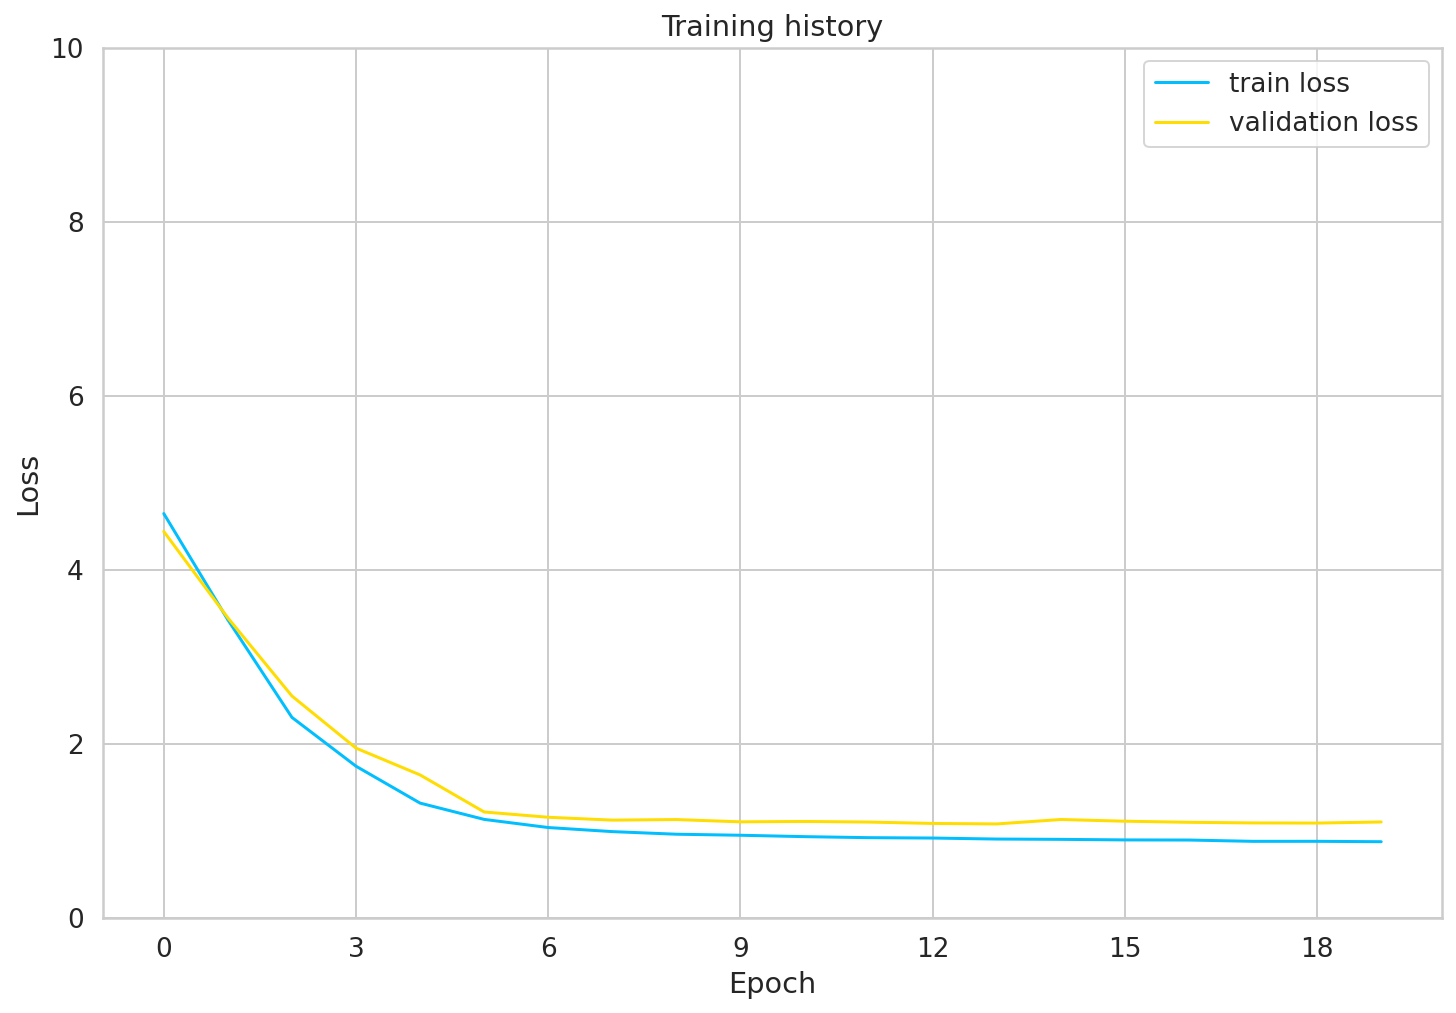

In [71]:
ax = plt.subplot(1, 1, 1)
ax.plot(history["train_loss"], label="train loss")
ax.plot(history["val_loss"], label="validation loss")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.set_ylim([0, 10])
plt.title("Training history");

In [72]:
def get_predictions(model, data_loader, device):
  model = model.eval()

  predictions = []
  ground_truths = []

  with torch.no_grad():
    for item in data_loader:
    
      sequence = item["sequence"].to(device)
      prev_pois = item["prev_pois"].to(device)
      labels = item["label"].to(device)
      
      outputs = model((sequence, prev_pois))

      predictions.append(outputs.squeeze())
      ground_truths.append(labels)

  return torch.stack(predictions), torch.stack(ground_truths)

In [73]:
predictions, labels = get_predictions(model, test_dataloader, device)

In [ ]:
for k in Config.Evaluation.K_VALUES:
  accuracy = Accuracy(top_k=k)
  accuracy = accuracy(torch.softmax(predictions, dim=1).cpu(), labels.cpu()).item()

  precision = Precision(num_classes=n_classes, top_k=k)
  precision = precision(torch.softmax(predictions, dim=1).cpu(), labels.cpu()).item()

  recall = Recall(num_classes=n_classes, top_k=k)
  recall = recall(torch.softmax(predictions, dim=1).cpu(), labels.cpu()).item()

  print(f"k={k}: accuracy {accuracy} precision {precision} recall {recall}")

k=5: accuracy 0.9119868874549866 precision 0.18239736557006836 recall 0.9119868874549866
k=10: accuracy 0.9727421998977661 precision 0.09727422147989273 recall 0.9727421998977661
k=15: accuracy 0.9858784675598145 precision 0.06572522968053818 recall 0.9858784675598145
k=20: accuracy 0.9901477694511414 precision 0.04950739070773125 recall 0.9901477694511414
